In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [15]:
# Load dataset
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")

In [16]:
# Step 2: Preview the dataset
print("Dataset shape:", df.shape)
print("First 5 rows:\n", df.head())

Dataset shape: (12684, 26)
First 5 rows:
        destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never

In [17]:
print("\nColumn Types:\n", df.dtypes)


Column Types:
 destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object


In [18]:
#  Null Count & Percentage
nulls = df.isnull().sum()
null_pct = (nulls / len(df)) * 100
print("\nNull % per Column:\n", pd.concat([nulls, null_pct], axis=1, keys=['null_count', 'null_percentage']))


Null % per Column:
                       null_count  null_percentage
destination                    0         0.000000
passanger                      0         0.000000
weather                        0         0.000000
temperature                    0         0.000000
time                           0         0.000000
coupon                         0         0.000000
expiration                     0         0.000000
gender                         0         0.000000
age                            0         0.000000
maritalStatus                  0         0.000000
has_children                   0         0.000000
education                      0         0.000000
occupation                     0         0.000000
income                         0         0.000000
car                        12576        99.148534
Bar                          107         0.843582
CoffeeHouse                  217         1.710817
CarryAway                    151         1.190476
RestaurantLessThan20         

In [19]:
#  Drop Columns with >50% Nulls
df.drop(columns=['car'], inplace=True)  # Has ~99% missing

In [20]:
#  Drop Rows with >30% NaNs
df = df[df.isnull().mean(axis=1) < 0.3]

In [21]:
#  Drop unwanted column (optional)
if 'direction_opp' in df.columns:
    df.drop(columns=['direction_opp'], inplace=True)

In [22]:
#  Sort table by 'destination' (if needed)
df.sort_values(by='destination', inplace=True)

In [23]:
#  Product-wise classification (treating 'coupon' as product)
print("\nCoupon (Product) Usage Count:\n", df['coupon'].value_counts())


Coupon (Product) Usage Count:
 coupon
Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: count, dtype: int64


In [24]:
#  Customer Engagement (Average acceptance per coupon)
engagement = df.groupby('coupon')['Y'].mean().sort_values(ascending=False)
print("\nEngagement Rate by Coupon (Accepted %):\n", engagement)


Engagement Rate by Coupon (Accepted %):
 coupon
Carry out & Take away    0.735478
Restaurant(<20)          0.707107
Coffee House             0.499249
Restaurant(20-50)        0.441019
Bar                      0.410015
Name: Y, dtype: float64


In [25]:
#  Year-wise Coupon Use (simulate year from 'expiration')
df['year'] = df['expiration'].map({'1d': '2021', '2h': '2022', '1h': '2023'})
yearly_coupon = df.groupby(['year', 'coupon'])['Y'].sum().reset_index()
top_by_year = yearly_coupon.sort_values(['year', 'Y'], ascending=[True, False]).drop_duplicates('year')
print("\nMost Accepted Coupon Each Year:\n", top_by_year)


Most Accepted Coupon Each Year:
    year                 coupon     Y
1  2021  Carry out & Take away  1138
7  2022           Coffee House   962


In [26]:
#  Classification of Coupons by Product
coupon_summary = df.groupby('coupon')['Y'].agg(['count', 'sum', 'mean']).rename(columns={
    'count': 'Total Offered', 'sum': 'Accepted', 'mean': 'Acceptance Rate'
})
print("\nCoupon Performance Summary:\n", coupon_summary)


Coupon Performance Summary:
                        Total Offered  Accepted  Acceptance Rate
coupon                                                         
Bar                             2017       827         0.410015
Carry out & Take away           2393      1760         0.735478
Coffee House                    3996      1995         0.499249
Restaurant(20-50)               1492       658         0.441019
Restaurant(<20)                 2786      1970         0.707107


In [27]:
#  Feature Engineering
X = pd.get_dummies(df.drop(columns=['Y']), drop_first=True)
y = df['Y']

In [28]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#  Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
#  Predictions & Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      1111
           1       0.75      0.83      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.75      0.74      0.75      2537
weighted avg       0.75      0.75      0.75      2537



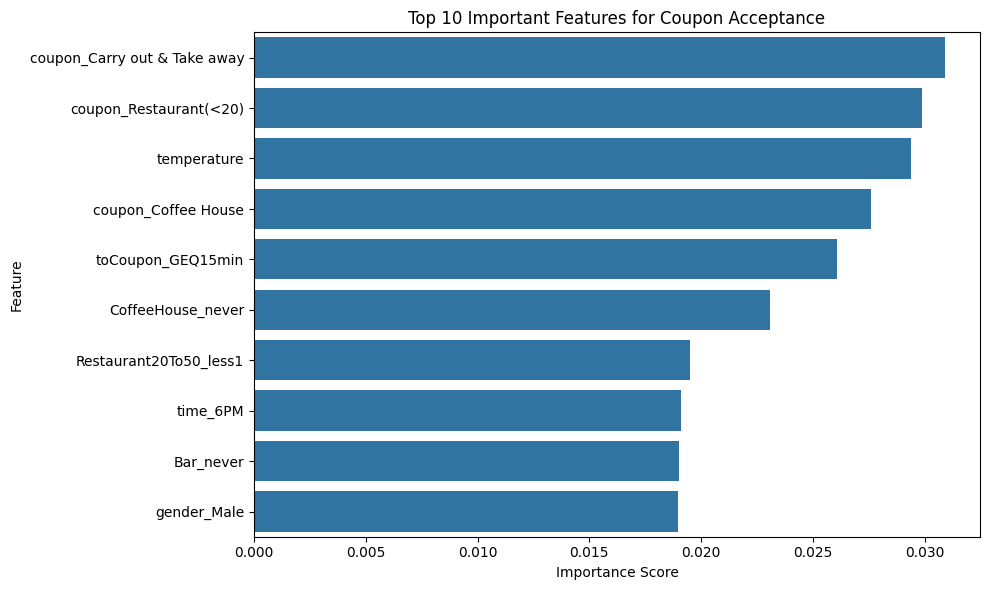

In [31]:
#  Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 10 Important Features for Coupon Acceptance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()